In [1]:
ct1 = '../data/2018_2008.tsv'
ct2 = '../data/2018_2006.tsv'
scores = '../out/ko_scores_s288c.txt'
old = '../data/parsons_2006.tsv'
old1 = '../out/hillenmeyer2008/lscores.tsv'
old2 = '../out/hillenmeyer2008/zscores.tsv'
old3 = '../out/hillenmeyer2008/pvalues.tsv'
old4 = '../out/hillenmeyer2008/lscores_het.tsv'
old5 = '../out/hillenmeyer2008/zscores_het.tsv'
old6 = '../out/hillenmeyer2008/pvalues_het.tsv'

In [2]:
# plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

plt.rc('font', size=12)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# other imports
import random
import numpy as np
import pandas as pd
from scipy import stats

In [4]:
random.seed(42)

In [5]:
d = {}
for b, h1, h2, h in pd.read_table(ct1).values:
    if str(h2) == 'nan':
        h2 = None
    else:
        h2 = str(int(h2))
    d[b] = (h1, h2)

In [6]:
m = pd.read_table(scores, index_col=0).loc['S288C'].reset_index()
m['condition'] = [x.lower()
                  for x in m['condition']]
m['signed-qvalue'] = [np.sign(x) * -np.log10(y)
                      for x,y in m[['score', 'qvalue']].values]
m['phenotype'] = [1 if x is True
                  else 0 for x in m['qvalue'] < 0.05]
m = m.set_index(['condition', 'gene'])
m.sort_index(inplace=True)
o1 = pd.read_table(old1, index_col=0)
o1.index = [x.split(':')[0] for x in o1.index]
o3 = pd.read_table(old3, index_col=0)
o3.index = [x.split(':')[0] for x in o3.index]
o1 = o1.stack()
o1.name = 'log-ratio'
o3 = o3.stack()
o3.name = 'p-value'
o = o1.to_frame().join(o3.to_frame())
o = o.swaplevel()
o = o.sort_index()
o['signed-pvalue'] = [np.sign(x) * -np.log10(y)
                      for x,y in o[['log-ratio', 'p-value']].values]
o['phenotype'] = [1 if x is True
                  else 0 for x in o['p-value'] < 1E-4]
o1 = pd.read_table(old4, index_col=0)
o1.index = [x.split(':')[0] for x in o1.index]
o3 = pd.read_table(old6, index_col=0)
o3.index = [x.split(':')[0] for x in o3.index]
o1 = o1.stack()
o1.name = 'log-ratio'
o3 = o3.stack()
o3.name = 'p-value'
s = o1.to_frame().join(o3.to_frame())
s = s.swaplevel()
s = s.sort_index()
s['signed-pvalue'] = [np.sign(x) * -np.log10(y)
                      for x,y in s[['log-ratio', 'p-value']].values]
s['phenotype'] = [1 if x is True
                  else 0 for x in s['p-value'] < 1E-4]
o = pd.concat([o, s])

In [7]:
cs = {}
rc = {}
for b, (h1, h2) in d.items():
    if h2 is None:
        c = sorted({x[0] for x in o.index
                    if x[0].split(':')[1] == h1})
    else:
        c = sorted({x[0] for x in o.index
                    if x[0].split(':')[1] == h1
                    and x[0].split(':')[2] == h2})
    for cond in c:
        rc[cond] = b
    cs[b] = c
o = o.rename(index=rc)

In [8]:
idx1 = {(x[0], x[1]) for x in m.index}
idx2 = {(x[0], x[1]) for x in o.index}
idx = idx1.intersection(idx2)

In [9]:
m = m.loc[sorted(idx),]
o = o.loc[sorted(idx), ]

In [10]:
o.index.names = ['condition', 'gene']

In [11]:
res = []
for c in cs:
    if c not in {x[0] for x in m.index}:
        continue
    if c not in {x[0] for x in o.index}:
        continue
    
    g1 = set(m[m['phenotype'] == 1].loc[c].index)
    g2 = set(o[o['phenotype'] == 1].loc[c].index)
    
    res.append((c, 'no',
                len(g1), len(g2),
                len(g1.intersection(g2)),
                len(g1.intersection(g2)) / len(g1),
                len(g1.intersection(g2)) / len(g2)))
    for i in range(1000):
        rg = {x[1] for x in o[o['phenotype'] == 1].sample(n=o[o['phenotype'] == 1].loc[c].shape[0]).index}
        res.append((c, 'phenotypes',
                    len(g1), len(rg),
                    len(g1.intersection(rg)),
                    len(g1.intersection(rg)) / len(g1),
                    len(g1.intersection(rg)) / len(rg)))
        rg = {x[1] for x in o.sample(n=o[o['phenotype'] == 1].loc[c].shape[0]).index}
        res.append((c, 'all',
                    len(g1), len(rg),
                    len(g1.intersection(rg)),
                    len(g1.intersection(rg)) / len(g1),
                    len(g1.intersection(rg)) / len(rg)))

r = pd.DataFrame(res,
                 columns=['condition',
                          'random',
                          'phenotypes1',
                          'phenotypes2',
                          'overlap',
                          'overlap1',
                          'overlap2'])

In [12]:
cd = {'ph7.5  (48h)': 'pH 7.5 (48h)',
      'cantharidin (72h)': 'Cantharidin (48h)',
      '37ºc (48h)': '37ºc (48h)',
      'cuso4 (72h)': 'CuSO$_{4}$ (72h)',
      'hydroxyurea (48h)': 'Hydroxyurea (48h)',
      'methotrexate (48h)': 'Methotrexate (48h)',
      'ph8.5 (48h)': 'pH 8.5 (48h)',
      'nacl 0.6m (72h)': 'NaCl 0.6M (72h)',
      'sorbitol 1m (48h)': 'Sorbitol 1M (48h)'}
r['condition'] = [cd.get(x, x)
                  for x in r['condition']]

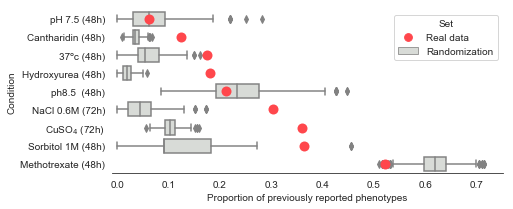

In [13]:
plt.figure(figsize=(7, 3))

h1 = sns.boxplot(data=r[r['random'] == 'all'],
            x='overlap1',
            y='condition',
            hue='random',
            palette=[sns.xkcd_rgb['light grey']],
            order=r[r['random'] == 'no'].sort_values('overlap1')['condition'].values)
h2 = sns.stripplot(data=r[r['random'] == 'no'],
              x='overlap1',
              y='condition',
              hue='random',
              palette=[sns.xkcd_rgb['light red']],
              jitter=0,
              size=10,
              order=r[r['random'] == 'no'].sort_values('overlap1')['condition'].values)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1],
           ['Real data', 'Randomization'],
           title='Set')

sns.despine(left=True)
plt.xlim(-0.01)

plt.xlabel('Proportion of previously reported phenotypes')
plt.ylabel('Condition')

plt.savefig('comparison.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('comparison.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);